# Comparative Analysis of Chemical Composition in Red and White Wines: A Study of Volatile Acidity

<b> Group 18 Members: </b> Vivaan Wadhwa(88889191), Katie Archer (84677194), Katelyn Thomas (40530578), Justin Lieu (15032485)

In [2]:
# Required libraries
library(tidyverse)
install.packages("infer")
library(infer)
library(repr)
library(dplyr)
library(readr)
options(repr.plot.width=8, repr.plot.height=8)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.4     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



In [3]:
# Reading in the data
url <- "https://archive.ics.uci.edu/static/public/186/wine+quality.zip"

# Define the local file name for the downloaded ZIP file
zip_file <- "data/wine_quality.zip"

# Download the ZIP file from the URL
download.file(url, destfile = zip_file)

# Unzip the downloaded file
unzip(zip_file, exdir = "data")

## Introduction

The goal of the project is to explore the average level of Volatile Acidity in Red and White wine. The dataset, [Wine Quality](https://archive.ics.uci.edu/dataset/186/wine+quality), is taken from [UCI Machine Learning Repository](https://archive.ics.uci.edu/datasets).

The dataset includes 12 attributes describing 

- ```Fixed Acidity```
- ```Volatile Acidity```
- ```Citric Acid```
- ```Residual Sugar```
- ```Chlorides```
- ```Free Sulfur Dioxide```
- ```Total Sulfur Dioxide```
- ```Density```
- ```pH```
- ```sulphates```
- ```alcohol```
- ```quality```

### Research Question

How do the levels of <b>volatile acidity</b> differ between <b>red</b> and <b>white wines</b>, and are there statistically significant variations in this chemical component between the two wine types?

Our attribute of interest for this project is:

- ```Volatile Acidity```: Volatile acidity in the context of wine refers to the presence of volatile acids, primarily acetic acid.  It is a key factor in wine quality and can impact the wine's flavor and aroma.

To conduct research, we will be exploring the average levels (location parameter) of <b>volatile acidity</b> for each of the wines as well as variance (scale parameter).

Volatile acidity plays a pivotal role in the winemaking process, and exhibits substantial variations across different wines. A study conducted by Babincev and Jović in 2021 delves into the chemical composition of white and red wines, revealing that red wine tends to have higher acidity levels compared to white wine. This finding underscores the importance and relevance of further investigation of volatile acidity.

## Exploratory Data Analysis

### Wrangling the data

First, we read in the red wine and white wine data and check to see if there are any missing values. We also add a column to 
each dataset to indicate the type of wine. Seeing that there are no missing values, there is no need to remove any rows and we proceed by combining the data into one data frame.

In [4]:
# Read in the red and white wine data

wine_red_data <- read_delim("data/winequality-red.csv", delim = ";", show_col_types = FALSE) |>
                    mutate(type = "red")
wine_white_data <- read_delim("data/winequality-white.csv", delim = ";", show_col_types = FALSE)|>
                    mutate(type = "white")
# Check if we have missing values
sum(is.na(wine_white_data))
sum(is.na(wine_red_data)) 

[1] 0

[1] 0

In [5]:
# Combining the red/white wine data and adding proper column names to the dataframe

wine_data <- rbind(wine_red_data, wine_white_data)
colnames(wine_data) <- c("fixed.acidity","volatile.acidity","citric.acid","residual.sugar",
                         "chlorides","free.sulfur.dioxide","total.sulfur.dioxide","density",
                         "pH","sulphates","alcohol","quality","type")
head(wine_data)

fixed.acidity,volatile.acidity,citric.acid,residual.sugar,chlorides,free.sulfur.dioxide,total.sulfur.dioxide,density,pH,sulphates,alcohol,quality,type
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
7.4,0.70,0.00,1.9,0.076,11,34,0.9978,3.51,0.56,9.4,5,red
7.8,0.88,0.00,2.6,0.098,25,67,0.9968,3.20,0.68,9.8,5,red
7.8,0.76,0.04,2.3,0.092,15,54,0.9970,3.26,0.65,9.8,5,red
11.2,0.28,0.56,1.9,0.075,17,60,0.9980,3.16,0.58,9.8,6,red
7.4,0.70,0.00,1.9,0.076,11,34,0.9978,3.51,0.56,9.4,5,red
7.4,0.66,0.00,1.8,0.075,13,40,0.9978,3.51,0.56,9.4,5,red


Now that we have combined the two datasets, we drop all the unnecessary columns to isolate our attribute of focus (volatile acidity) and the wine type.

In [6]:
wine_data_specific <- wine_data %>%
                        select(volatile.acidity, type)
head(wine_data_specific)

volatile.acidity,type
<dbl>,<chr>
0.70,red
0.88,red
0.76,red
0.28,red
0.70,red
0.66,red


In [7]:
dim(wine_data_specific)

[1] 6497    2

# Preliminary Analysis #

We begin by conducting some preliminary analysis to explore our data. Here we plot the sample distribution for our attribute of interest, volatile acidity, using colour to differentiate between the red and white wine observations.

#### Figure 1: Histogram of volatile acidity (red vs. white)

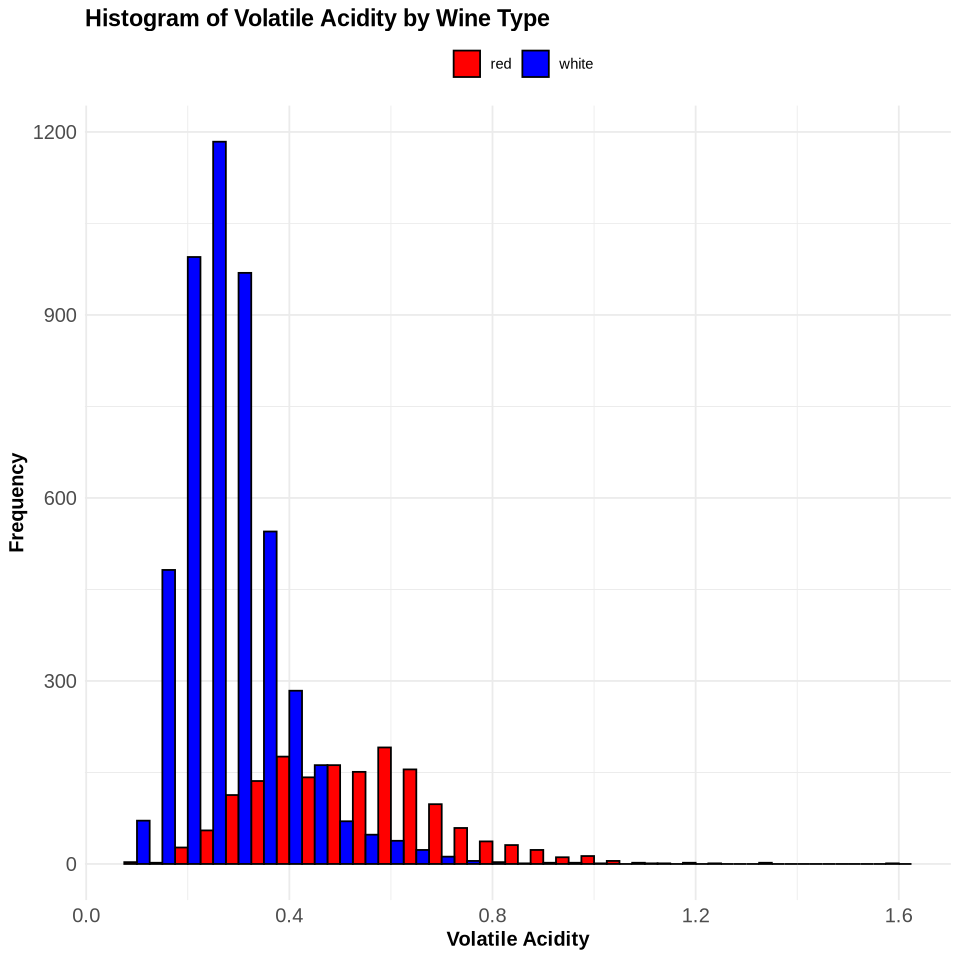

In [8]:
# Histogram of volatile acidity against the respective wine type

ggplot(wine_data_specific, aes(x = volatile.acidity, fill = type)) +
  geom_histogram(binwidth = 0.05, position = "dodge", color = "black") +
  labs(title = paste("Histogram of Volatile Acidity by Wine Type"), x = "Volatile Acidity", y = "Frequency") +
  scale_fill_manual(values = c("red" = "red", "white" = "blue")) +
  theme_minimal() +
  theme(legend.title = element_blank(),
        legend.position = "top",  # Change the legend position
        plot.title = element_text(size = 14, face = "bold"),  # Title style
        axis.text = element_text(size = 12),  # Axis label text size
        axis.title = element_text(size = 12, face = "bold")) 

The histogram clearly illustrates a contrast in the mean concentration of volatile acids between red and white wines in our sample. White wine appears to have a much lower mean concentration than red wine, hence the value of conducting a hypothesis test. 

We also produce a boxplot to more easily see the difference in distribution of volatile acid concentration between the 2 wine types. As can be seen below, each type of wine exhibits a unique distribution pattern, emphasizing the disparity observed in their chemical composition.

#### Figure 2: Side-by-side boxplots of volatile acidity (red vs. white)

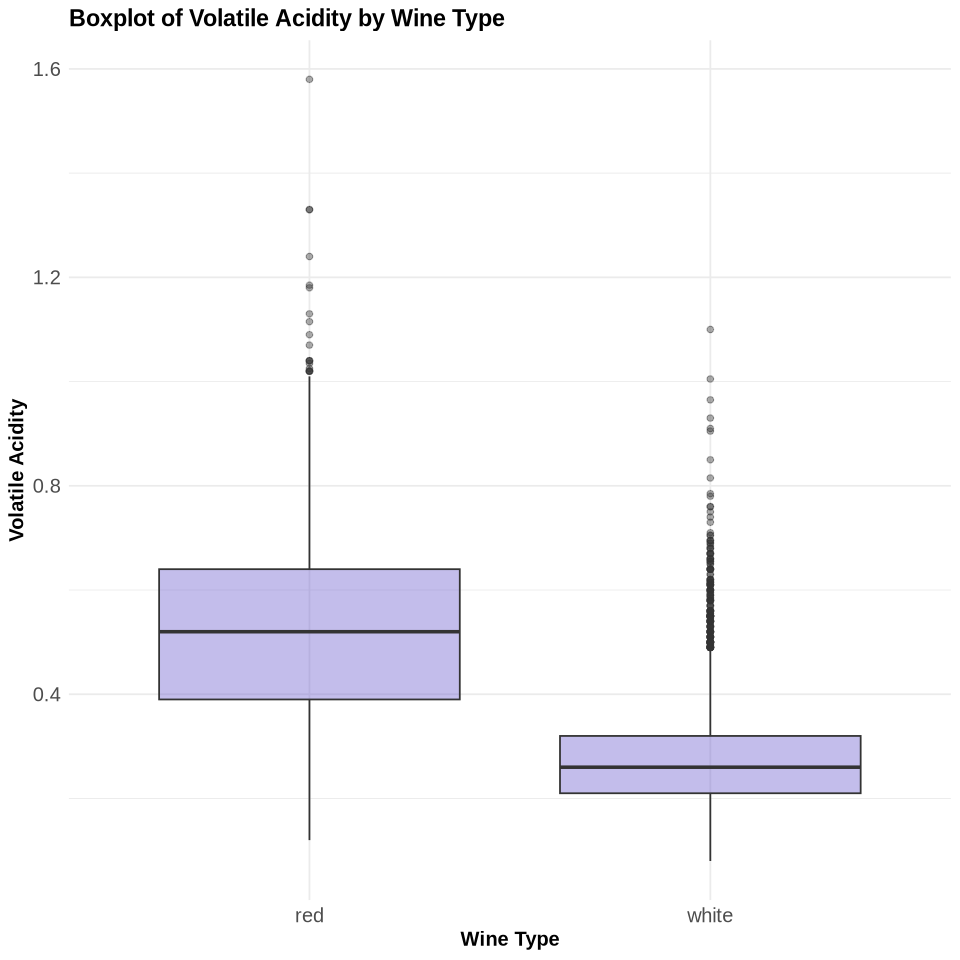

In [9]:
ggplot(wine_data_specific, aes(x = type, y = volatile.acidity)) +
      geom_boxplot(fill = "slateblue", alpha = 0.4) +
      labs(title = paste("Boxplot of Volatile Acidity by Wine Type", sep = " "), x = "Wine Type", y = "Volatile Acidity") +
      theme_minimal() +
      theme(legend.title = element_blank(),
            legend.position = "top",  # Change the legend position
            plot.title = element_text(size = 14, face = "bold"),  # Title style
            axis.text = element_text(size = 12),  # Axis label text size
            axis.title = element_text(size = 12, face = "bold"))

# Methods and Results

## Overview

We will be conducting a hypothesis test at the 5% significance level via asymptotics as well as via permutation, in order to compare the methods when examining the difference in mean volatile acidity between red and white wine. Our null hypothesis is

$$H_{0}: \mu_{\text{Volatile Acidity of Red Wine}} - \mu_{\text{Volatile Acidity of White Wine}} = 0$$ 

and our alternative hypothesis is 

$$H_{a}: \mu_{\text{Volatile Acidity of Red Wine}} - \mu_{\text{Volatile Acidity of White Wine}} \neq 0$$

We will also be creating a 95% confidence interval in order to propose a plausible range of values for the true difference in mean volatile acididty across the 2 types of wine. We will compare the confidence intervals produced through simulation-based and aymptotic methods. 

In addition to the difference in mean volatile acidity, we will also conduct exploration of the difference in variance between the two wine types.

### Central Limit Theorem

- <b>Random</b>: The sampling must be done at random.
- <b>Independence of Sample</b>: Each observation in the sample must be unrelated to one another.
- <b>Sample Size</b>: The sample size should not exceed 10% of the total population.

As the conditions mandated by the Central Limit Theorem have been satisfied, it is reasonable to proceed with the assumption of normality for statistical analyses.

## Exploration of Difference in Means

### Hypothesis Test: Asymptotic Method

Given that our sample meets the conditions set by the Central Limit Theorem (CLT), allowing us to confidently apply theoretical inference techniques, we opt for a 2-sample t-test. In this scenario, the population standard deviation remains unknown to us. Therefore, our test statistic is computed as:

$$\normalsize t = \frac{(\bar{x}_1 - \bar{x}_2)}{\sqrt{\frac{s_1^2}{n_1} + \frac{s_2^2}{n_2}}}$$

In [28]:
red_wine <- wine_data_specific |>
            filter(type == "red")

white_wine <- wine_data_specific |>
            filter(type == "white")

x_bar_1 <- mean(red_wine$volatile.acidity)
x_bar_2 <- mean(white_wine$volatile.acidity)

cat("Observed Difference in Means:",(x_bar_1 - x_bar_2))

red_wine_sd <- sd(red_wine$volatile.acidity)
white_wine_sd <- sd(white_wine$volatile.acidity)
n1 <- nrow(red_wine)
n2<- nrow(white_wine)

pooled_sample_sd <- sqrt((red_wine_sd^2 / n1) + (white_wine_sd^2 / n2))

test_statistic <- (x_bar_1 - x_bar_2)/pooled_sample_sd
cat("\nTest Statistic:",test_statistic)

Observed Difference in Means: 0.2495794
Test Statistic: 53.05909

We calculate the degrees of freedom using the following formula:

$$\normalsize v = \frac{{\left(\frac{{s_1^2}}{{n_1}} + \frac{{s_2^2}}{{n_2}}\right)^2}}{{\frac{{s_1^4}}{{n_1^2 \cdot (n_1 - 1)}} + \frac{{s_2^4}}{{n_2^2 \cdot (n_2 - 1)}}}}
$$



In [11]:
degrees_freedom <- (red_wine_sd^2 / n1 + white_wine_sd^2 / n2)^2 /
                    ((red_wine_sd^2)^2 / (n1^2 * (n1 - 1)) + (white_wine_sd^2)^2 / (n2^2 * (n2 - 1)))

degrees_freedom

[1] 1938.938

Now, we will calculate the confidence interval.

In [12]:
ci_asy <- tibble(
          lower_ci = qt(0.025, degrees_freedom) + (x_bar_1 - x_bar_2),
          upper_ci = qt(0.975, degrees_freedom) + (x_bar_1 - x_bar_2))
ci_asy

lower_ci,upper_ci
<dbl>,<dbl>
-1.711609,2.210768


Thus, through an asymptotic approach, we are 95% "confident" that the true difference in mean volatile acidity in the population lies between $-1.711609$ and $2.210768$.

We then calculate the p-value for the two-tailed hypothesis test, done below:

In [13]:
# Calculate p-value using pt() for a two-tailed test
p_value <- 2 * pt(abs(test_statistic), df = degrees_freedom, lower.tail = FALSE)

# Check if p-value is extremely small
if (p_value < 0.001) {
  p_value <- "< 0.001"
}

p_value

[1] "< 0.001"

With a $p-$value below $0.001$, we can reject the null hypothesis with confidence at a 5% significance level.

### Hypothesis Test: Permutation Method

In order to perform a simulation-based hypothesis test, we first calculate the observed test statistic. That is, the observed difference in volatile acidity between red and white wine in our dataset.


In [14]:
obs_diff_in_means <- wine_data_specific %>%
    specify(volatile.acidity ~ type) %>%
    calculate(stat = "diff in means", order = c("red", "white"))

obs_diff_in_means

stat
<dbl>
0.2495794


Next, we create the null distribution, based on our null hypothesis shown below. To achieve this, we specify our formula and generate 1000 replicates using the infer package. Since our test statistic is the difference in means, we use the permutation method. We calculate the difference in means for each replicate by subtracting the mean of white wine from the mean of red wine.

$$H_{0}: \mu_{\text{Volatile Acidity of Red Wine}} - \mu_{\text{Volatile Acidity of White Wine}} = 0$$

In [15]:
set.seed(1234) #do not change

null_dist <- wine_data_specific %>%
    specify(volatile.acidity ~ type) %>%
    hypothesize(null = "independence") %>%
    generate(reps = 1000, type="permute") %>%
    calculate(stat = "diff in means", order = c("red", "white"))
head(null_dist)

replicate,stat
<int>,<dbl>
1,0.0002439446
2,-0.0047458338
3,-0.0020580729
4,-0.0101172078
5,-0.0181929338
6,0.0018781696


After obtaining the null distribution, we visualize it and shade in the p-value based on the observed statistic we calculated earlier.

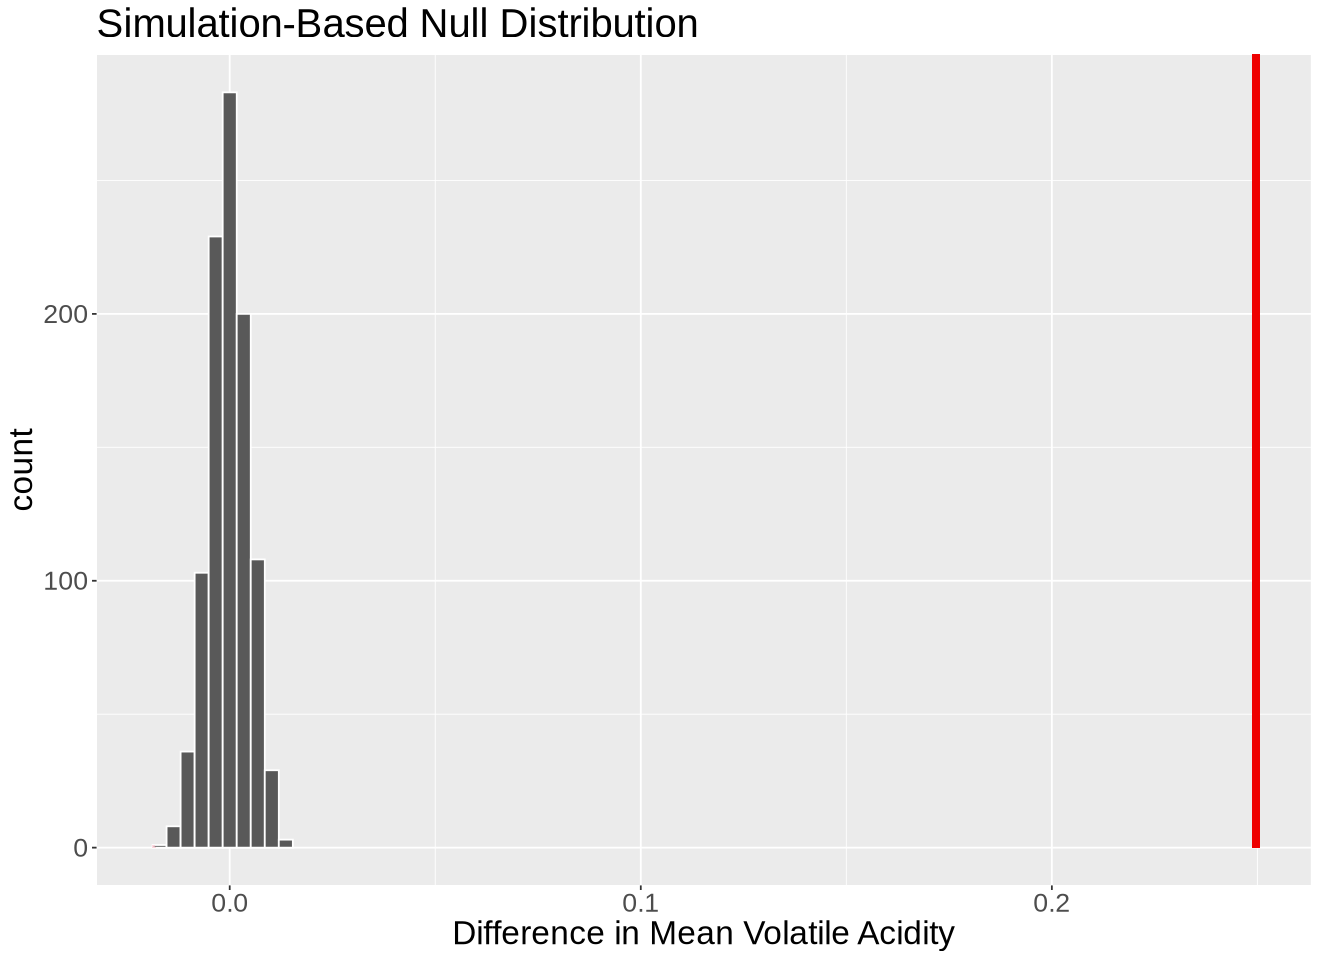

In [16]:
options(repr.plot.width=11, repr.plot.height=8)
visualize(null_dist, bins = 10) + 
    shade_p_value(obs_stat = obs_diff_in_means, direction = "both") +
    theme(
    plot.title = element_text(size = 24), 
    axis.title.x = element_text(size = 20),  
    axis.title.y = element_text(size = 20),  
    axis.text.x = element_text(size = 16), 
    axis.text.y = element_text(size = 16)) +
    xlab("Difference in Mean Volatile Acidity")

We take the p-value by using the get_p_value function:

In [17]:
result <- suppressWarnings({
  p_val <- null_dist %>%
    get_p_value(obs_stat = obs_diff_in_means, direction = "both")
  p_val
})

if (result == 0) {
  result <- "< 0.001"
}

print(result)

[1] "< 0.001"


To determine if the difference in means between red and white wines is significant, we compare the p-value to our pre-specified significance level. Since the $p-$value is  less than $0.001$, we confidently reject the null hypothesis at a 5% significance level.

### Confidence Interval: Bootstrapping Method

To construct our confidence interval using a simulation-based approach, we take 1000 bootstrap samples using the infer package and then take the 95% confidence interval.

In [18]:
# Confidence Interval
confidence_interval <- wine_data_specific |>
                           specify(volatile.acidity ~ type) %>%
                            generate(reps=1000, type='bootstrap')|>
                            calculate(stat='diff in means', order = c("red", "white"))

ci_boot <- confidence_interval |> get_ci(0.95, type = "percentile")
ci_boot

lower_ci,upper_ci
<dbl>,<dbl>
0.2404427,0.2583048


We visualize this confidence interval below on the bootstrap distribution:

#### Figure 3: Simulation-Based Null Distribution Plot for Diff in Means

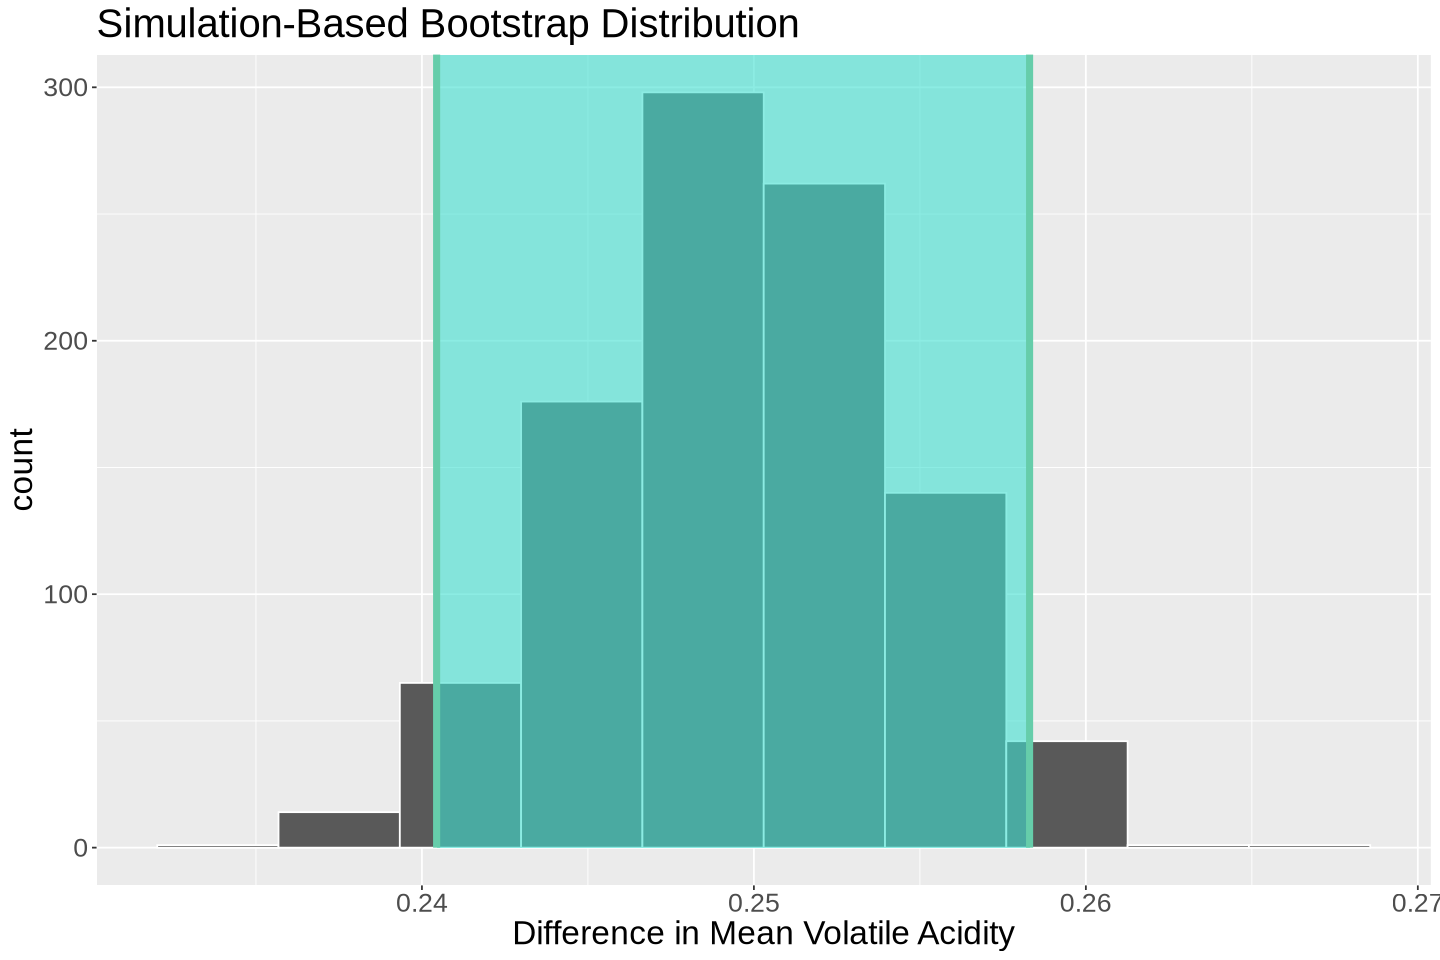

In [19]:
options(repr.plot.width=12, repr.plot.height=8)
visualize(confidence_interval, bins = 10) + 
    shade_ci(endpoints = ci_boot) +
    theme(
    plot.title = element_text(size = 24), 
    axis.title.x = element_text(size = 20),  
    axis.title.y = element_text(size = 20),  
    axis.text.x = element_text(size = 16), 
    axis.text.y = element_text(size = 16)) +
    xlab("Difference in Mean Volatile Acidity")

Thus, through a bootstrap approach, we are 95% "confident" that the true difference in mean volatile acidity in the population lies between 0.240 and 0.259.

### Comparison of Methods:

Based on our analysis, both methods strongly suggest that the mean volatile acidity differs between the two types of wines. Additionally, both methods yield a similar plausible range of values for the true difference in mean volatile acididty between red and white wine, as determined from the 95% confidence intervals.

## Exploration of Difference in Variances (via Bootstrapping)

The ```infer``` package does not provide functionality to produce bootstrap samples for difference in variances. Thus, we calculate the bootstrap samples by calculating samples independently for both types and then subtracting them. This method gives us the difference in variances and setting the seed ensures the same samples are subtracted from one another.

In [20]:
set.seed(1234) #do not change

wine_white_resample_var <- wine_data_specific %>%
                    filter(type == "white")%>%
                    specify(response=volatile.acidity)%>%
                    generate(reps=1000, type = "bootstrap")%>%
                    calculate(stat="sd")%>%
                    mutate(stat = stat^2)

wine_diff_var <- wine_data_specific %>%
                    filter(type == "red")%>%
                    specify(response=volatile.acidity)%>%
                    generate(reps=1000, type = "bootstrap")%>%
                    calculate(stat="sd")%>%
                    mutate(stat = stat^2 - wine_white_resample_var$stat)

print(nrow(wine_diff_var))
head(wine_diff_var)

[1] 1000


replicate,stat
<int>,<dbl>
1,0.02152759
2,0.02079490
3,0.02162123
4,0.02081992
5,0.02263301
6,0.01986772


We then calculate the observed difference in variances of volatile acidity for the wine types in our dataset/sample:

In [21]:
#Calculating the observed difference in variance

red_wine <- wine_data_specific |>
            filter(type == "red")

white_wine <- wine_data_specific |>
            filter(type == "white")

observed_diff_var <- sd(red_wine$volatile.acidity)^2 - sd(white_wine$volatile.acidity)^2
observed_diff_var

[1] 0.02190284

To gain insight into a plausible range of values for the true difference in variances for the population, we construct a 95% confidence interval using the bootstrap samples produced above. We also visualize the distribution with the interval below, where we include a vertical line marking the observed difference in variancse in our sample for reference.

lower_ci,upper_ci
<dbl>,<dbl>
0.01913747,0.02483508


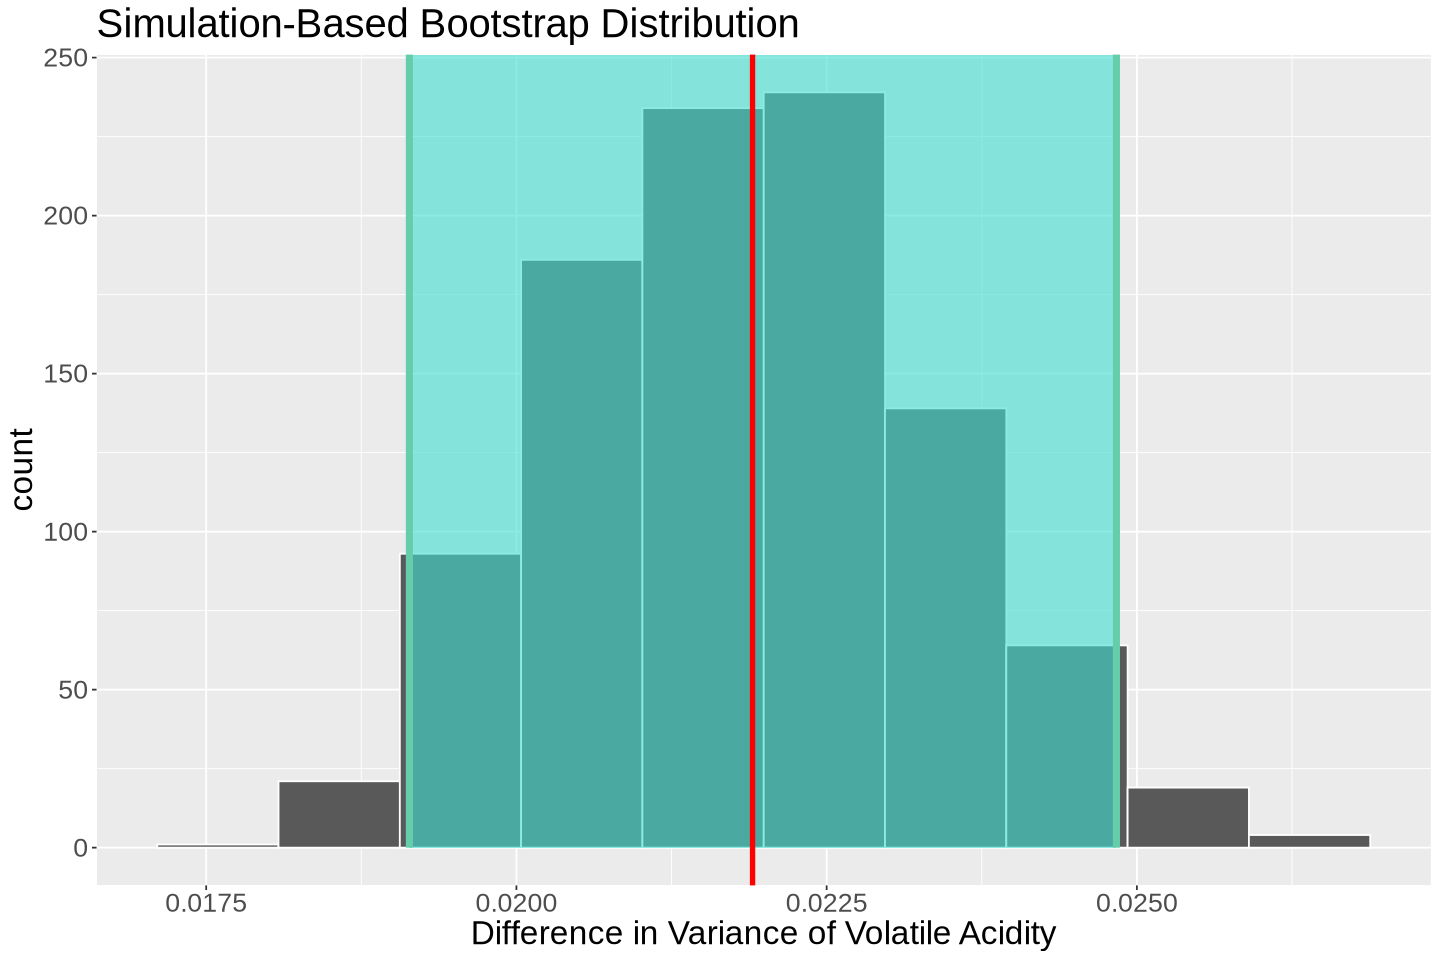

In [22]:
#Confidence Interval
wine_var_ci <- wine_diff_var %>% 
               get_confidence_interval(level = 0.95, type = "percentile")
wine_var_ci

var_ci_plot <- visualize(wine_diff_var, bins = 10) +
               shade_ci(endpoints = wine_var_ci) +
               theme(
               plot.title = element_text(size = 24), 
               axis.title.x = element_text(size = 20),  
               axis.title.y = element_text(size = 20),  
               axis.text.x = element_text(size = 16), 
               axis.text.y = element_text(size = 16)) +
               xlab("Difference in Variance of Volatile Acidity") +
               geom_vline(xintercept = observed_diff_var, colour = "red", lwd = 1.5)
var_ci_plot

As can be determined from the confidence interval, we are 95% "confident" that the true difference in variances for the population is between 0.019 and 0.025. This plausible range of values is not far from 0 (no difference in variances), which underscores the need for further investigation into variance and hypothesis testing. However, our current knowledge restricts us from conducting analyses using asymptotic methods, thus limiting our exploration in this regard.

<b> The stuff written above makes sense to me, rather than having to do a null model. But we can discuss. </b>

#### Creating a Null Model for Variance

In [23]:
null_model <- wine_diff_var |>
            mutate(stat = stat - observed_diff_var)
head(null_model)

replicate,stat
<int>,<dbl>
1,-0.0003752510
2,-0.0011079349
3,-0.0002816113
4,-0.0010829197
5,0.0007301744
6,-0.0020351207


#### Figure 4: Simulation-Based Bootstrap Distribution of Diff in Variance

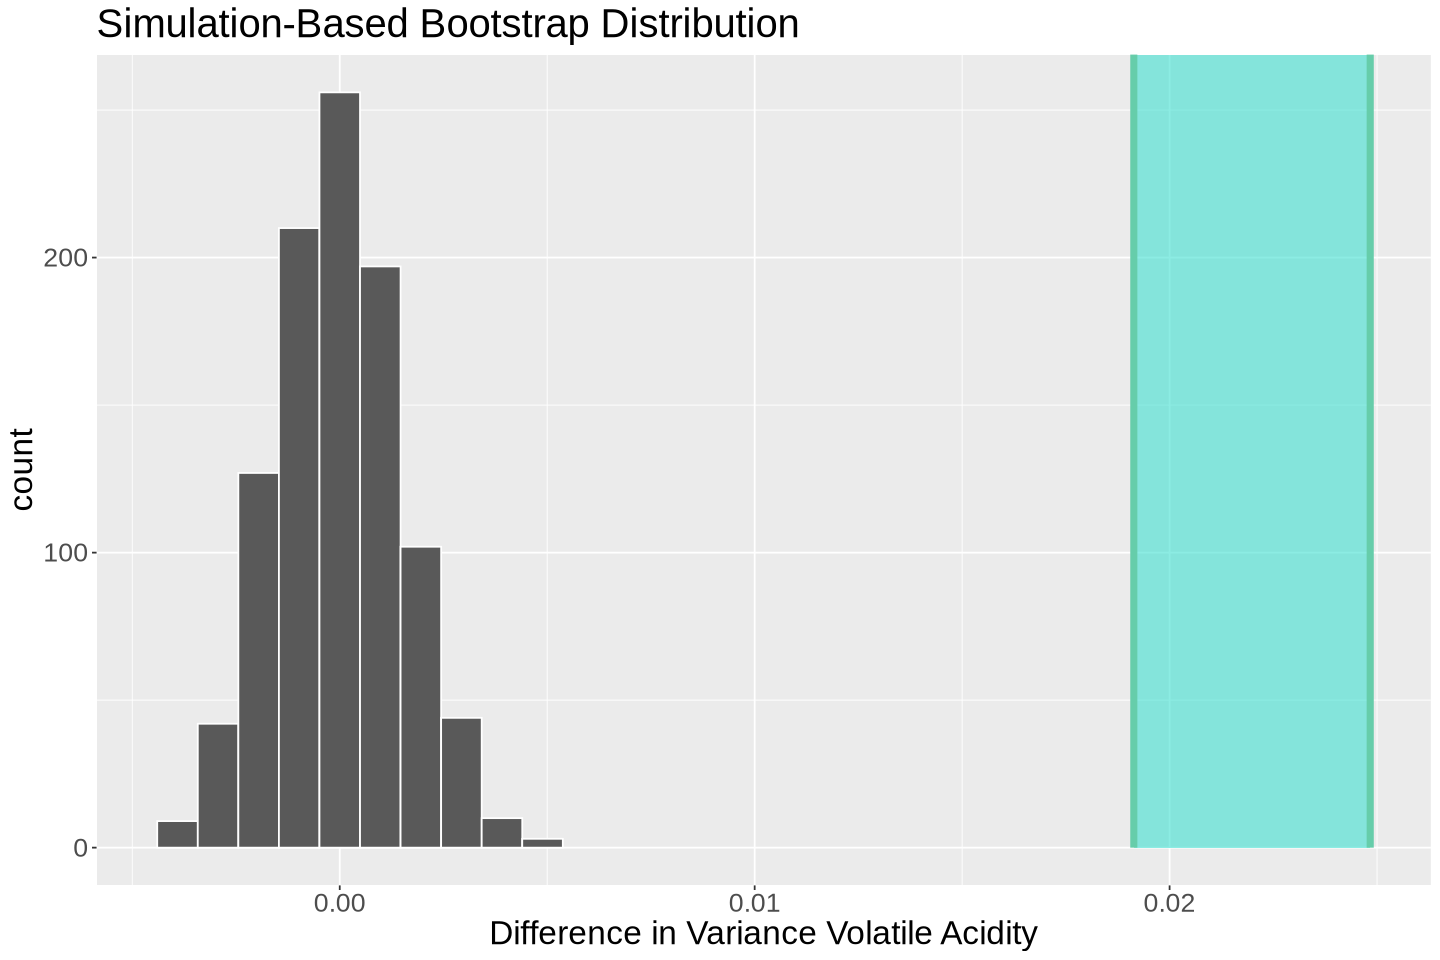

In [24]:
options(repr.plot.width=12, repr.plot.height=8)
visualize(null_model, bins = 10) + 
    shade_ci(endpoints = wine_var_ci) +
    theme(
    plot.title = element_text(size = 24), 
    axis.title.x = element_text(size = 20),  
    axis.title.y = element_text(size = 20),  
    axis.text.x = element_text(size = 16), 
    axis.text.y = element_text(size = 16)) +
    xlab("Difference in Variance Volatile Acidity")

As we can see, our calculated confidence interval for the difference in variance also differs from our null model. This underscores the need for further investigation into variance and hypothesis testing. However, our current knowledge restrict us from conducting analyses using Asymptotic methods, thus limiting our exploration in this regard.

## Discussion

### Findings

Examining the null distribution under the hypothesis of no difference in mean volatile acidity between red and white wine, we find compelling evidence to reject the null hypothesis (H0). Our null hypothesis, asserting 
$H_{0}: \mu_{\text{Volatile Acidity of Red Wine}} - \mu_{\text{Volatile Acidity of White Wine}} = 0$, is not supported by our analysis. The calculated p-value is significantly less than 0, indicating that the probability of obtaining such extreme results by chance alone under the assumption of the null hypothesis is essentially negligible. Both of our calculated confidence intervals also coincide with our conclusion. Therefore, we can conclude from our test that we reject the null hypothesis, and that there is a significant difference in volatile acidity between red and white wine with a 95% level of confidence.

We also also did a short analysis on the difference in variances between red and white wine's volatile acidity. We found that our confidence interval varies from what our null model would've been (null assuming no difference in variances).

### Limitations/Drawbacks

- Our knowledge of volatile acidity and winemaking prior to the analysis was limited, so choosing a null hypothesis setting our mean difference equal to 0 was a trivial decision.
- It is possible that there are other wines out there that are more heavily weighted as the wine industry is always changing. As a result, our sample may fail to be fully representative of those changes.
- Our analysis is based on the assumption that volatile acidity is not affected by other factors (i.e. we only examined the difference between red and white wine, but there could be differences between other types of red/white wine like cabernet, merlot, pinot noir, etc.)

### Future Ideas/Questions

- What other specific factors contribute to the observed difference in volatile acidity in red wines vs. white wines?
- How does the difference in volatile acidity translate to variation in the taste of red wine and white wine?
- What is the impact of aging wine on volatile acidity?
- Are there certain patterns that can be derived on what consumers deem to be the best level of volatile acidity?

## References

- Babincev, L.M., Jović, S. Determination of the amount of volatile acids in oxidized wines and neutralization of these by using chemical reagents and biological materials. Biomass Conv. Bioref. 13, 4717–4725 (2023). https://doi.org/10.1007/s13399-021-01339-7
- Kelly M. Volatile Acidity in Wine PennState Extension https://extension.psu.edu/volatile-acidity-in-wine